<h1> Spiking Neural Networks </h1>

<h3> Introduction </h3>

Neural networks have driven recent breakthroughs in artificial intelligence by enabling machines to observe patterns and make predictions from data. These systems consist of layered "neurons" that process information through mathematical operations [[1]](#1). Despite drawing loose inspiration from the brain, conventional neural networks bear little resemblance to biological neurons in how they actually function [\[1,](#1)[2\]](#2). Spiking neural networks represent an alternative approach, one that more faithfully mimics the brain's temporal dynamics and is remarkably energy-efficient by processing information through discrete events rather than continuous signals [\[2,](#2)[5,](#5)[6\]](#6).

<h3> How do Spiking Neural Networks work </h3>

SNNs differ from traditional artificial neural networks in that their internal temporal states make the timing of input data critical for neuron activation. For example, if an input to neuron A decays before neuron B spikes, neuron C—connected to both A and B—will be less likely to spike. Spikes are discrete events that emulate the action potentials of biological neurons. The presence of temporal states allows SNNs to process information asynchronously [[4]](#4), in contrast to the synchronous layer-wise processing of artificial neural networks, which typically operate in either a forward or backward (backpropagation) direction. In SNNs, neurons in different layers may spike simultaneously, indicating the asynchronous data processing observed in the brain and contributing to its energy efficiency. However, this asynchronous processing prevents SNNs from fully utilizing learning algorithms such as backpropagation.[\[4,](#4)[6\]](#6). 

<h4> Non-differentiable nature of spiking functions </h4>

Each spike in an SNN is generated by a variation of the unit step function, whose derivative is the Dirac delta function (recall DSP course). The Dirac delta creates challenges for gradient-based learning because it is zero everywhere except at the spike, where it approaches infinity [[8]](#8).. Since gradient descent requires continuous values for weight updates, backpropagation cannot be effectively applied to SNNs. This limitation is significant, as modern deep learning primarily depends on backpropagation and gradient descent [[4,5]](#4). Without meaningful gradients, state-of-the-art optimization techniques and deep learning frameworks cannot be utilized. However, alternative solutions have been developed to address this issue.

<h4>Backpropagation for SNNs</h4>

The surrogate gradient (SG) method introduces an alternative approach to gradient-based learning in SNNs. This technique replaces the derivative of the non-differentiable spike function with the derivative of a smooth, differentiable approximation during backpropagation [\[4,](#4)[5,](#5)[6\]](#6). For a thorough mathematical explanation of SG, see Surrogate Gradient Learning in Spiking Neural Networks by Neftci et al [[4]]($4).

<h4>Implicit gradient descent for SNNs</h4>

Contrastive Hebbian learning (CHL) serves as an alternative to backpropagation. CHL divides learning into two phases: a free phase and a clamped phase. In the free phase, the network input is fixed while the output varies and converges to equilibrium, after which a standard Hebbian weight update is applied. In the clamped phase, the network output is fixed at a desired value, and the system converges to a new equilibrium. Weights are then updated again, this time using a negative anti-Hebbian update rule [[9]](#9).

Equilibrium propagation (EP) is a more refined form of CHL. It also consists of two phases. In the free phase, in the case of EP, the network also receives fixed input, but it settles to an equilibrium state that minimizes its energy function [\[9,](#9)[10,](#10)[16\]](#16). In the clamped phase, sometimes called the nudged phase in the case of EP, the neurons are gently nudged towards target values, and the network converges to a new equilibrium. The weights are updated in the same way as in CHL [[9]](#9). 

What makes EP and CHL appealing is that they only require local information. The weight update depends entirely on the activities of its pre- and post-synaptic neurons, so we don’t need to propagate the signal backward to learn[[9]](#9).



<h3>Brian2</h3>

Brian2 is a versatile Python library designed for simulating spiking neural networks, offering researchers and developers an intuitive framework for computational neuroscience. Brian2 provides a high-level interface that enables users to define complex neural models using straightforward, equation-based syntax while efficiently managing the underlying numerical computations. The library supports a broad range of neuron models, synaptic plasticity rules, and network architectures, making it suitable for applications ranging from small-scale studies to large-scale brain simulations [[13]](#13). 

I will showcase the implementation of Leaky Integrate-and-Fire (LIF) neurons, a widely used simplified neuron model in computational neuroscience that captures the essential dynamics of neural spiking behavior [\[2,](#2)[13\]](#13).





In [329]:
from brian2 import *

# This function prevents mixing brian2 objects created before initialization. Its good practice to include it.
start_scope()

N = 25                  # 1 Number of neurons 
tau = 10*ms             # 2 Membrane reaction time
vr = -70*mV             # 3 Resting state
vt0 = -55*mV            # 4 Spike threshold
delta_vt0 = 5*mV        # 5 Threshold jump
tau_t = 10*ms           # 6 Threshold adaptation
sigma = 0.5*(vt0-vr)    # 7 Noise
v_drive = 2*(vt0-vr)    # 8 The driving input
duration = 100*ms       # 9 Duration of the simulation 

# Neurons' dynamics 
eqs = """
dv/dt = (delta_vt0 + vr - v)/tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0-vt)/tau_t : volt
"""

# Reset behaviour
reset = """
v = vr
vt += delta_vt0
"""


Lets go over all the variables that we initialized. 

1. First we have N, that is the number of neurons that we are going to stimulate in our group.
2. Tau represents the time that the membrane voltage of our neuron will react to input.
3. Vr represents the resting state of a neuron.
4. When the voltage reaches Vt0 the neuron spikes.
5. Delta rises the threshold after spike. 
6. Tau_t tells us how fast will the threshold return to normal after a spike.
7. Sigma is a noise that we will introduce to create slight fluctuations in voltage of neurons
8. V_drive is the current that will push all neurons towards firing
9. This is simple the duration of our simulation

Equations

Membrane potential [\[2,](#2)[13\]](#13): 

$$\frac{dv}{dt} = \frac{v_{drive} + v_r - v}{\tau} + \frac{\sigma*x_i}{\sqrt{\tau}}$$


Firstly, so called leaky integrator [[11]](#11) $$\frac{v_{drive} + v_r - v}{\tau}$$ This function pulls the voltage of a neuron towards a spike, tau controls how fast the voltage changes.

Secondly the noise $$\frac{\sigma*x_i}{\sqrt{\tau}}$$ This introduces random noise to neurons. x_i is the Gaussian white noise [[12]](#12), it introduces randomness.


Threshold dynamics:
$$\frac{dv_t}{dt} = \frac{(v_t0-v_t)}{\tau_t} $$

This slowly brings back the voltage of a neuron back to vt0 (resting state) after a non-spike change.

Reset:

After a spike the voltage will go to vr and the vt (threshold) will increase by delta_vt0.


WARNING    'j' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value np.int32(21). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


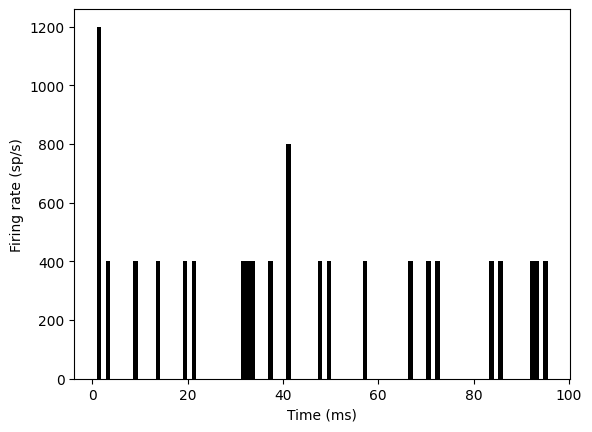

In [330]:
neurons = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')

neurons.v = 'rand()*(vt0-vr)+vr'
neurons.vt = vt0

S = Synapses(neurons, neurons)
S.connect(condition="i!=j", p=0.15)

spike_monitor = SpikeMonitor(neurons)
voltage_monitor = StateMonitor(neurons, 'v', record=[0, 1, 2, 3])
M = StateMonitor(neurons, 'v', record=True)

run(duration)

spike_trains = spike_monitor.spike_trains()

#NOTE graph taken from official Brian2 guide -- https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html
_ = hist(spike_monitor.t/ms, 100, histtype='stepfilled', facecolor='k', weights=list(ones(len(spike_monitor))/(N*defaultclock.dt)))
xlabel('Time (ms)')
ylabel('Firing rate (sp/s)');

In this cell we have run the simulation. First we created neuron group with variables that were defined above. Next two lines changes the initial values of the NeuronGroup object, we set initial membrane voltage to a random value between vr and vt0. We also set the spike threshold vt to vt0. 

We also created synapses, once again it is pretty straightforward, just declare Synapses object and call connection() with a condition and probability. 
After random synapses were created, we created a few objects like SpikeMonitor or StateMonitor. They are here just for plotting, we don't need to concern ourselves with it. 
All thats left to do is to run the simulation for a specified amount of time. 
I took and created some plots. Plots in this cell and the next cell were taken from the Brian2 official guide [[13]](#13). I created the last plot. 
I encourage you to play around with the initial variables, and equations to see how the behaviour of the neuron group changes! 

Text(0, 0.5, 'Target neuron index')

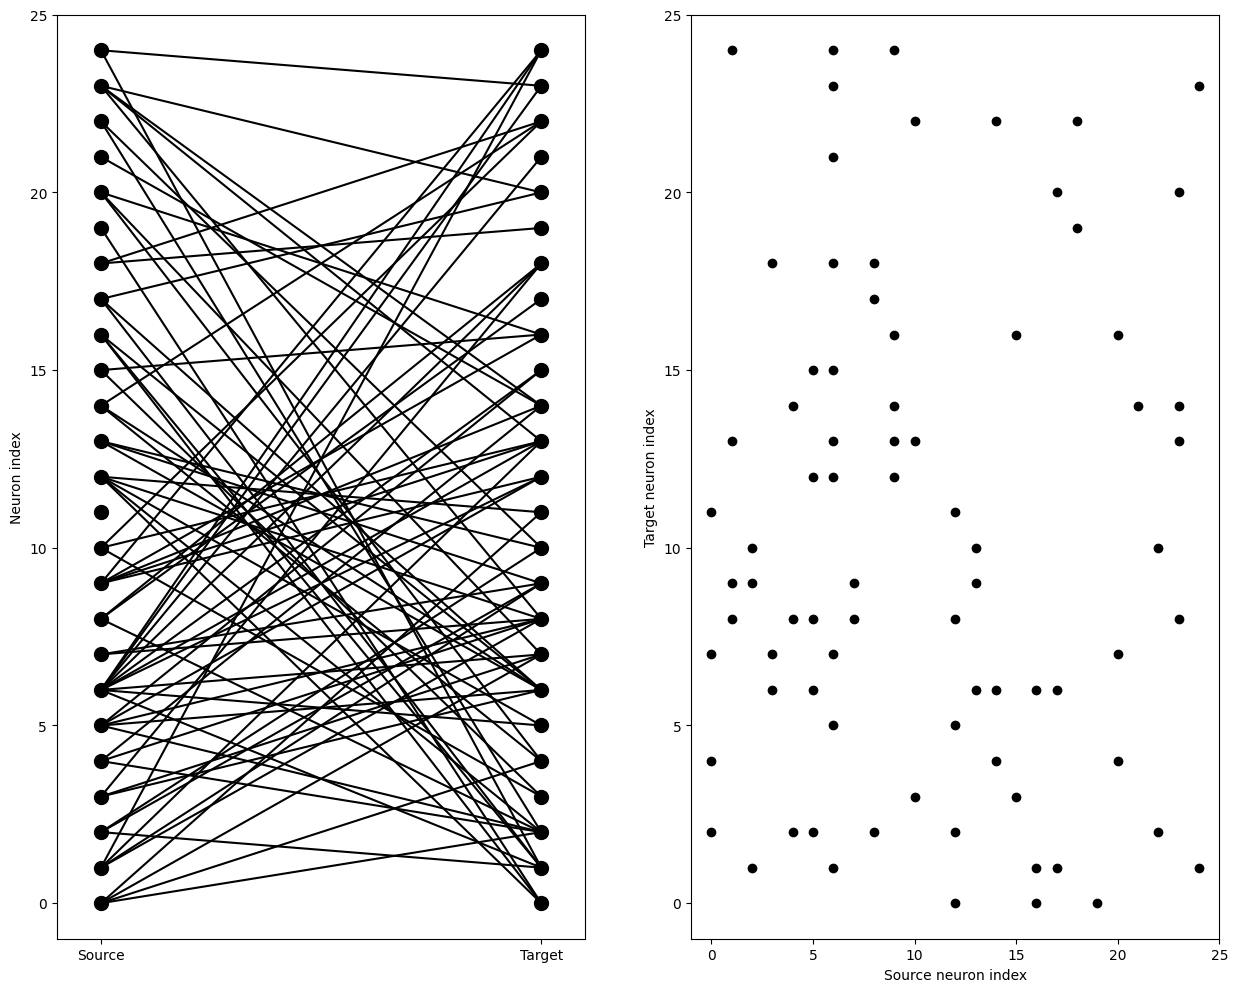

In [331]:
#NOTE graph taken from https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html
Ns = len(S.source)
Nt = len(S.target)
figure(figsize=(15, 12))
subplot(121)
plot(zeros(Ns), arange(Ns), 'ok', ms=10)
plot(ones(Nt), arange(Nt), 'ok', ms=10)
for i, j in zip(S.i, S.j):
    plot([0, 1], [i, j], '-k')
xticks([0, 1], ['Source', 'Target'])
ylabel('Neuron index')
xlim(-0.1, 1.1)
ylim(-1, max(Ns, Nt))
subplot(122)
plot(S.i, S.j, 'ok')
xlim(-1, Ns)
ylim(-1, Nt)
xlabel('Source neuron index')
ylabel('Target neuron index')



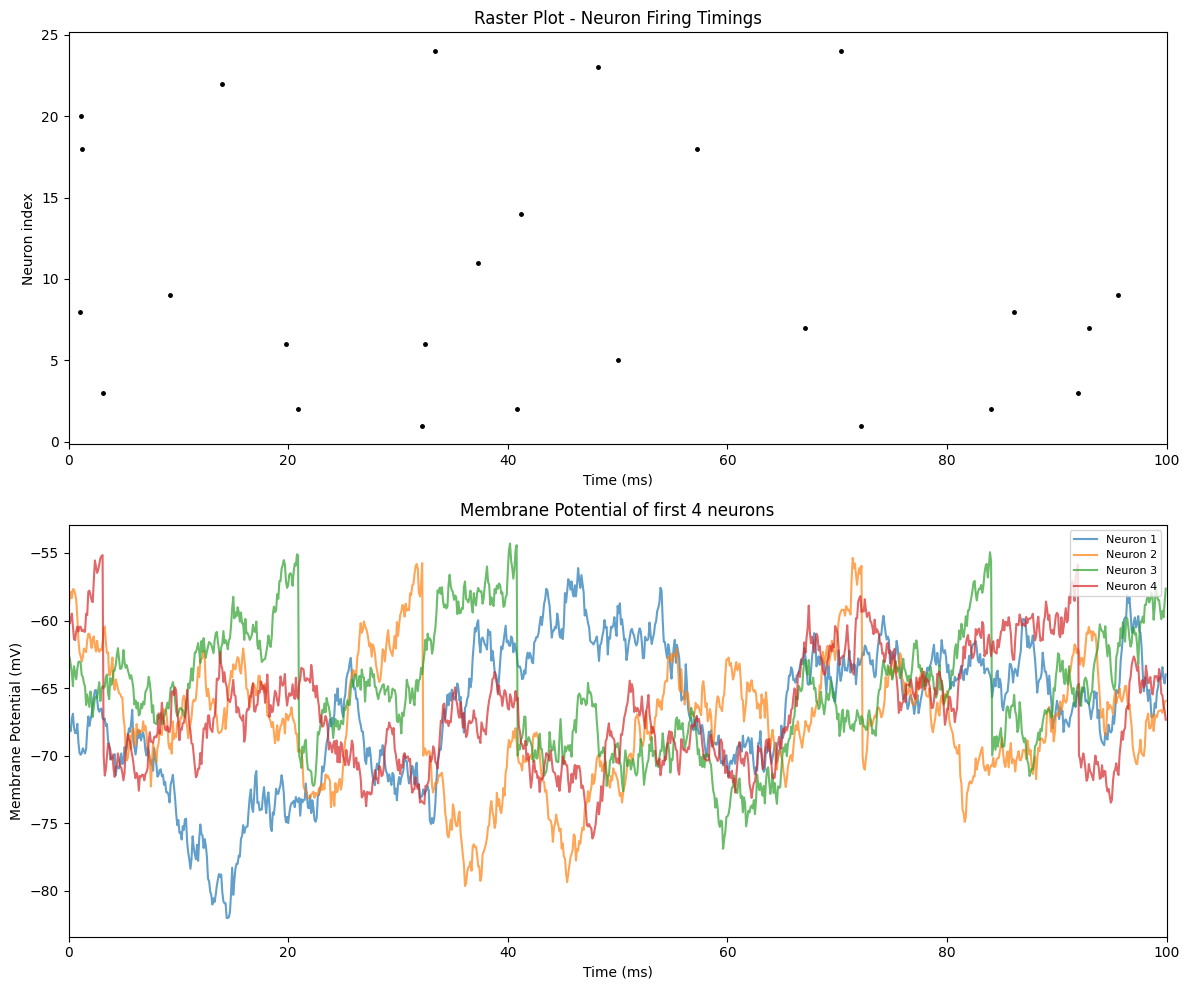

In [332]:
# Some more visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# spike timings
axes[0].plot(spike_monitor.t/ms, spike_monitor.i, '.k', markersize=5)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Neuron index')
axes[0].set_title('Raster Plot - Neuron Firing Timings')
axes[0].set_xlim(0, duration/ms)

#  Membrane potential
for i in range(4):
    axes[1].plot(voltage_monitor.t/ms, voltage_monitor.v[i]/mV, 
                    label=f'Neuron {i+1}', alpha=0.7)
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Membrane Potential (mV)')
axes[1].set_title('Membrane Potential of first 4 neurons')
axes[1].legend(loc='upper right', fontsize=8)
axes[1].set_xlim(0, duration/ms)

plt.tight_layout()
plt.show()

Another way to portray our data is through sound. It may not seem like a practicality approach, but it may be a fun way to build intuition around the data we are working with. I have been inspired by the paper "Sonification and Visualization of Neural Data" by Chang, Mindy; Wang, Ge & Berger, Jonathan [[2]](#2). The methodology for the following function has been taken directly from this paper. 

In [333]:
# NOTE The idea for following functions has been taken from the paper "Sonification and Visualization of Neural Data" (2)
from midiutil import MIDIFile
import numpy as np

def avgRatePitch(neural_data, time_window, sampling_interval, 
                    pitch_range=(60, 84), rate_range=None):
    
    start_time, end_time = time_window
    
    # Create time bins
    time_points = np.arange(start_time, end_time, sampling_interval)
    n_samples = len(time_points)
    
    # Calculate firing rates for each time bin
    firing_rates = np.zeros(n_samples)
    
    for i, t in enumerate(time_points):
        bin_start = t
        bin_end = t + sampling_interval
        
        # Count spikes in this time window for all neurons
        total_spikes = 0
        for neuron_spikes in neural_data:
            # Count spikes that fall within this time bin
            spikes_in_bin = np.sum((neuron_spikes >= bin_start) & 
                                    (neuron_spikes < bin_end))
            total_spikes += spikes_in_bin
        
        # Calculate average firing rate (spikes per second per neuron)
        n_neurons = len(neural_data)
        firing_rates[i] = total_spikes / (n_neurons * sampling_interval)
    
    # Determine rate range for normalization
    if rate_range is None:
        min_rate = np.min(firing_rates)
        max_rate = np.max(firing_rates)
    else:
        min_rate, max_rate = rate_range
    
    # Map firing rates to pitch range
    min_pitch, max_pitch = pitch_range
    
    # Normalize and map to pitch
    if max_rate > min_rate:
        normalized_rates = (firing_rates - min_rate) / (max_rate - min_rate)
        pitches = min_pitch + normalized_rates * (max_pitch - min_pitch)
    else:
        # If all rates are the same, use middle pitch
        pitches = np.full(n_samples, (min_pitch + max_pitch) / 2)
    
    # Round to nearest MIDI note
    pitches = np.round(pitches).astype(int)
    
    # Clip to ensure within range
    pitches = np.clip(pitches, min_pitch, max_pitch)
    
    return pitches, time_points



def make_music(pitches, time_points, tempo=120):
    midi = MIDIFile(1)
    track = 0
    channel = 0
    volume = 100
    
    midi.addTempo(track, 0, tempo)
    
    for i, pitch in enumerate(pitches):
        if i < len(pitches) - 1:
            duration = time_points[i+1] - time_points[i]
        else:
            duration = time_points[1] - time_points[0]
        
        midi.addNote(track, channel, int(pitch), time_points[i], 
                    duration, volume)
    
    with open("neural_music.mid", "wb") as output_file:
        midi.writeFile(output_file)


In [334]:
"""
    Same as before, but we will make our simulations longer and have more neurons. 
"""

start_scope()

neurons1 = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
neurons2 = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
neurons3 = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')

volt_ini = 'rand()*(vt0-vr)+vr'

neurons1.v, neurons2.v, neurons3.v  = volt_ini, volt_ini, volt_ini
neurons1.vt, neurons2.vt, neurons3.vt = vt0, vt0, (vt0 + vt0*0.001)

S1 = Synapses(neurons1, neurons2)
S2 = Synapses(neurons2, neurons3)

S1.connect(p=0.15)
S2.connect(p=0.1)

spike_monitor1 = SpikeMonitor(neurons1)
spike_monitor2 = SpikeMonitor(neurons2)
spike_monitor3 = SpikeMonitor(neurons3)

run(1000*ms)

# Take all spikes and flatten it, make it float
all_spikes = [(spike_monitor1.t / ms).astype(float)/100, 
                (spike_monitor2.t / ms)/100, 
                (spike_monitor3.t / ms)/100]

pitches, time_points = avgRatePitch(
        neural_data=all_spikes,
        time_window=(0, 10),
        sampling_interval=0.21)

make_music(pitches, time_points)

This section will be added shortly 

Lastly I have prepared some real life data, this data has been taken from chimps. There are few neurons, to be precise neuronal clusters. [[1]](#1) 



In [335]:
from scipy.io import loadmat

""" This file is sort of messy may change later  """

data_files = [
    "neurons/m06cat003spk001a.mat",
    "neurons/m06cat003spk001b.mat",
]

all_spikes = []

for f in data_files:
    data = loadmat(f, simplify_cells=True)
    neuron_data = data['neuron']

    all_spikes.append(neuron_data[:200])  


<h3>snnTorch</h3>

I showcased some simple neuron simulation using Brian2, while it is a good choice for simulating neurons it is not ideal for training SNNs. If you would like to learn how to train actual SNN I recommend this guide by Jason Eshraghian and Fabrizio Ottati from Open Neuromorphic community [[7]](#7). This workshop will teach you all the basics you need to work with a simple SNN using snnTorch.


<h3>Discussion</h3>

While SNNs present us with promising future for computation, we need to keep in mind problems unique to this deep learning model. 


[NC-NL](https://nc-nl.nl/) is newly established organization that aims create momentum for a dutch neuromorphic computing innovations. The leading representative is Johan Mentink, Associate Professor at Radboud University.


<h3>Acknowledgments</h3>
In preparation for this assignment, I consulted several workshops organized by the Open Neuromorphic community and followed guides and tutorials available on the official Brian2 website. Some plots were taken directly from the Brian2 tutorials, as indicated alongside the corresponding code. Grammarly was used to reduce grammatical errors and improve overall writing quality. Additionally, ChatGPT assisted me in reviewing academic papers and online guides during my research.


<h3>References:</h3>

<a id='1'>[1]</a> Fangfang Lee. What is a neural network? https://www.ibm.com/think/topics/neural-networks 

<a id='2'>[2]</a> Ali Moezzi; The Complete Guide to Spiking Neural Networks (2023) https://pub.towardsai.net/the-complete-guide-to-spiking-neural-networks-d0a85fa6a64

<a id='3'>[3]</a> S.B. Moldakarimov, T.J. Sejnowski (2008) Neural Computation Theories of Learning https://doi.org/10.1016/B978-012370509-9.00086-3

<a id='4'>[4]</a> Neftci, Emre O.; Mostafa, Hesham; Zenke, Friedemann. Surrogate Gradient Learning in Spiking Neural Networks (2019). https://doi.org/10.48550/arXiv.1901.09948

<a id='5'>[5]</a> Sanaz M. Takaghaj; Jack Sampson. Rouser: Robust SNN training using adaptive threshold learning (2024) https://doi.org/10.48550/arXiv.2407.19566

<a id='6'>[6]</a> Sanaz M. Takaghaj; Jack Sampson. To Spike or Not to Spike, that is the Question (2025)	https://doi.org/10.48550/arXiv.2407.19566

<a id='7'>[7]</a> Jason Eshraghian; Fabrizio Ottati Hands-on With SnnTorch (2023) https://open-neuromorphic.org/workshops/hands-on-with-snntorch-jason-eshraghian/

<a id='8'>[8]</a> Dirac delta function https://en.wikipedia.org/wiki/Dirac_delta_function

<a id='9'>[9]</a> Beren Millidge; Yuhang Song; Tommaso Salvatori; Thomas Lukasiewicz; Rafal Bogacz BACKPROPAGATION AT THE INFINITESIMAL INFERENCE LIMIT OF ENERGY-BASED MODELS: UNIFYING PREDICTIVE CODING, EQUILIBRIUM PROPAGATION, AND CONTRASTIVE HEBBIAN LEARNING (2020) https://arxiv.org/pdf/2206.02629

<a id='10'>[10]</a> Benjamin Scellier; Equilibrium Propagation; https://bscellier.github.io/eqprop/eqprop.html

<a id='11'>[11]</a> Leaky integrator https://en.wikipedia.org/wiki/Leaky_integrator

<a id='12'>[12]</a> Gaussian white noise https://en.wikipedia.org/wiki/Gaussian_noise

<a id='13'>[13]</a> Introduction to Brian  https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html

<a id='14'>[14]</a> Zhang, J., Zhu, X., Zhou, H. et al. A large neuronal dataset for natural category-based free-gaze visual search in macaques. Sci Data 12, 779 (2025). https://doi.org/10.1038/s41597-025-05130-5

<a id='15'>[15]</a> Chang, Mindy & Wang, Ge & Berger, Jonathan. (2010). Sonification and Visualization of Neural Data. https://www.researchgate.net/publication/265165122_Sonification_and_Visualization_of_Neural_Data

<a id='16'>[16]</a> Benjamin Scellier; Yoshua Bengio; (2017) Equilibrium Propagation: Bridging the Gap between Energy-Based Models and Backpropagation https://doi.org/10.3389/fncom.2017.00024




